In [1]:
from sagemaker import RandomCutForest

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import json

In [3]:
aws_role = get_execution_role()


sm_role = sagemaker.get_execution_role()

aws_region = boto3.Session().region_name
sm_session = sagemaker.Session()
sm_client = boto3.client('sagemaker')

print(f"Using Role: {sm_role}")
s3_bucket = sm_session.default_bucket()
s3_bucket

Using Role: arn:aws:iam::287758680514:role/service-role/AmazonSageMaker-ExecutionRole-20231027T004238


'sagemaker-us-east-1-287758680514'

In [4]:
import pandas as pd
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv'
df = pd.read_csv(url, sep=',')

In [5]:
df

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [7]:
df['year'] = df['timestamp'].apply(lambda x: x.year)

In [8]:
df['month'] = df['timestamp'].apply(lambda x: x.month)

In [9]:
df['day'] = df['timestamp'].apply(lambda x: x.day)

In [10]:
df['hour'] = df['timestamp'].apply(lambda x: x.hour)

In [11]:
df['minute'] = df['timestamp'].apply(lambda x: x.minute)

In [12]:
df

,timestamp,value,year,month,day,hour,minute
0,2013-07-04 00:00:00,69.880835,2013,7,4,0,0
1,2013-07-04 01:00:00,71.220227,2013,7,4,1,0
2,2013-07-04 02:00:00,70.877805,2013,7,4,2,0
3,2013-07-04 03:00:00,68.959400,2013,7,4,3,0
4,2013-07-04 04:00:00,69.283551,2013,7,4,4,0
...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,72.370206,2014,5,28,11,0
7263,2014-05-28 12:00:00,72.172956,2014,5,28,12,0
7264,2014-05-28 13:00:00,72.046565,2014,5,28,13,0
7265,2014-05-28 14:00:00,71.825226,2014,5,28,14,0


In [13]:
anomaly_points = [
        ["2013-12-10 06:25:00.000000","2013-12-12 05:35:00.000000"],
        ["2013-12-15 17:50:00.000000","2013-12-17 17:00:00.000000"],
        ["2014-01-27 14:20:00.000000","2014-01-29 13:30:00.000000"],
        ["2014-02-07 14:55:00.000000","2014-02-09 14:05:00.000000"]
]

In [14]:
len(anomaly_points[0])

2

In [15]:
df['anomaly'] = 0

In [16]:
for start,end in anomaly_points:
    print (start, end)
    df.loc[  ((df['timestamp'] >= start) & (df['timestamp'] <= end)), ['anomaly']] = 1  

2013-12-10 06:25:00.000000 2013-12-12 05:35:00.000000
2013-12-15 17:50:00.000000 2013-12-17 17:00:00.000000
2014-01-27 14:20:00.000000 2014-01-29 13:30:00.000000
2014-02-07 14:55:00.000000 2014-02-09 14:05:00.000000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7267 non-null   datetime64[ns]
 1   value      7267 non-null   float64       
 2   year       7267 non-null   int64         
 3   month      7267 non-null   int64         
 4   day        7267 non-null   int64         
 5   hour       7267 non-null   int64         
 6   minute     7267 non-null   int64         
 7   anomaly    7267 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 454.3 KB


In [18]:
df[df['anomaly'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 3420 to 4891
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  190 non-null    datetime64[ns]
 1   value      190 non-null    float64       
 2   year       190 non-null    int64         
 3   month      190 non-null    int64         
 4   day        190 non-null    int64         
 5   hour       190 non-null    int64         
 6   minute     190 non-null    int64         
 7   anomaly    190 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 13.4 KB


In [19]:
df.index = df['timestamp']

In [20]:
df.drop(['timestamp'], axis=1, inplace=True)

In [21]:
df

,value,year,month,day,hour,minute,anomaly
timestamp,,,,,,,
2013-07-04 00:00:00,69.880835,2013,7,4,0,0,0
2013-07-04 01:00:00,71.220227,2013,7,4,1,0,0
2013-07-04 02:00:00,70.877805,2013,7,4,2,0,0
2013-07-04 03:00:00,68.959400,2013,7,4,3,0,0
2013-07-04 04:00:00,69.283551,2013,7,4,4,0,0
...,...,...,...,...,...,...,...
2014-05-28 11:00:00,72.370206,2014,5,28,11,0,0
2014-05-28 12:00:00,72.172956,2014,5,28,12,0,0
2014-05-28 13:00:00,72.046565,2014,5,28,13,0,0


In [23]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [27]:
normal_data = df[df['anomaly'] == 0]  # Adjust the condition based on your 'anomaly' values
anomalous_data = df[df['anomaly'] != 0]  # Adjust the condition accordingly


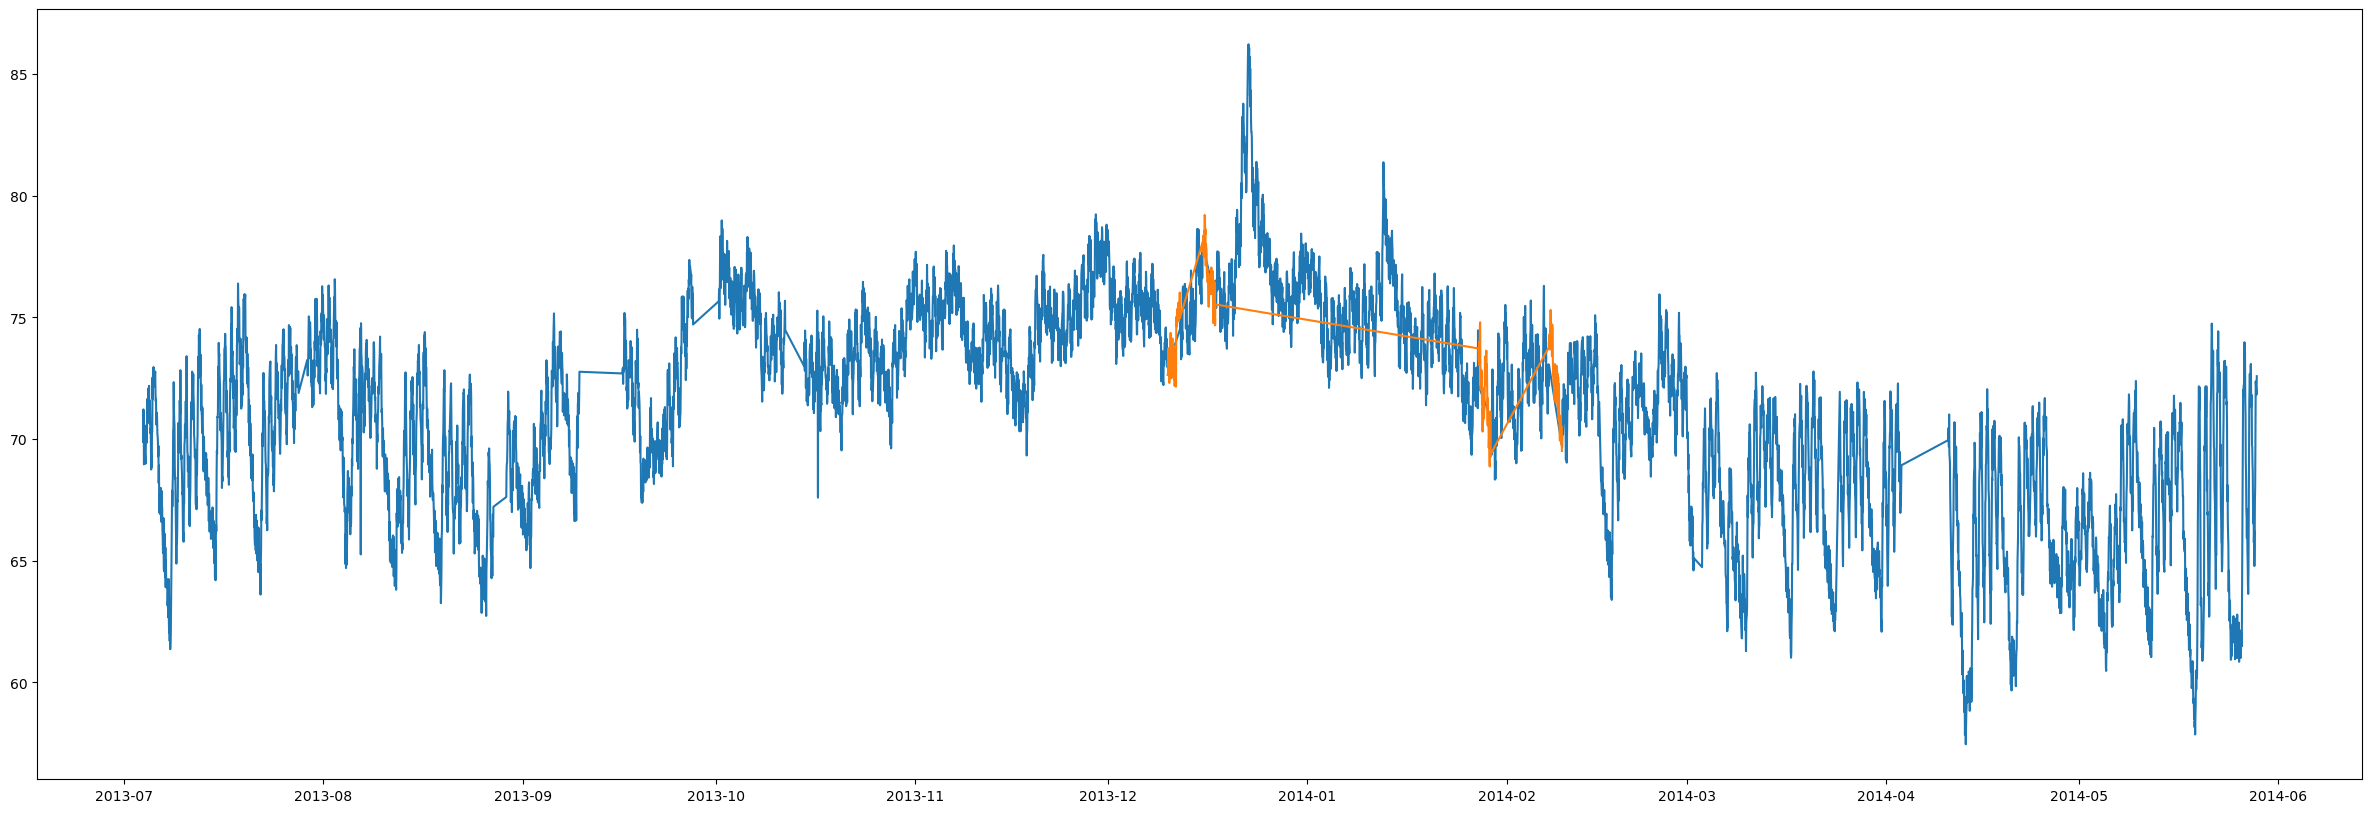

In [30]:
plt.figure(figsize=(30, 10))

plt.plot(normal_data.index, normal_data["value"])
plt.plot(anomalous_data.index, anomalous_data["value"])
           

In [22]:
df["value"].plot

In [26]:
# !conda install -y holoviews

In [18]:
import seaborn as sns
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

Matplotlib is building the font cache; this may take a moment.


ModuleNotFoundError: No module named 'holoviews'

In [22]:
from sagemaker import RandomCutForest

In [23]:
s3_bucket, prefix

NameError: name 'prefix' is not defined

In [35]:
prefix='randomcut'
rcf = RandomCutForest(role=sm_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location=f's3://{s3_bucket}/{prefix}/',
                      output_path=f's3://{s3_bucket}/{prefix}/output')

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [48]:
import numpy as np

In [50]:
multi = np.array([[65,  0, 46],
[22, 95, 16],
[73, 16, 90],
[44, 55, 80]])

In [51]:
multi.shape

(4, 3)

In [52]:
multi.reshape(-1,1)

array([[65],
       [ 0],
       [46],
       [22],
       [95],
       [16],
       [73],
       [16],
       [90],
       [44],
       [55],
       [80]])

In [53]:
multi.reshape(-1,1).shape

(12, 1)

In [42]:
df['value'].to_numpy().shape

(7267,)

In [40]:
df['value'].to_numpy()

array([69.88083514, 71.22022706, 70.87780496, ..., 72.04656545,
       71.82522648, 72.58408858])

In [43]:
df['value'].to_numpy().reshape(-1,1).shape

(7267, 1)

In [38]:
df['value'].to_numpy().reshape(-1,1)

array([[69.88083514],
       [71.22022706],
       [70.87780496],
       ...,
       [72.04656545],
       [71.82522648],
       [72.58408858]])

In [37]:
rcf.record_set(df['value'].to_numpy().reshape(-1,1))

(<class 'sagemaker.amazon.amazon_estimator.RecordSet'>, {'s3_data': 's3://sagemaker-us-east-1-287758680514/randomcut/RandomCutForest-2024-01-05-01-03-44-149/.amazon.manifest', 'feature_dim': 1, 'num_records': 7267, 's3_data_type': 'ManifestFile', 'channel': 'train'})

In [33]:
rcf.fit(rcf.record_set(df['value'].to_numpy().reshape(-1,1)))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: randomcutforest-2023-12-08-05-33-50-347


2023-12-08 05:33:50 Starting - Starting the training job......
2023-12-08 05:34:26 Starting - Preparing the instances for training......
2023-12-08 05:35:51 Downloading - Downloading input data...
2023-12-08 05:36:21 Training - Downloading the training image..................
2023-12-08 05:39:07 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[12/08/2023 05:39:31 INFO 139853672802112] Reading default conf

In [54]:
# rcf_interference = rcf.deploy(initial_instance_count=1, ins)


In [36]:
from sagemaker.serverless import ServerlessInferenceConfig

In [37]:
serverless_config = ServerlessInferenceConfig(
    memory_size_in_mb=2048,
    max_concurrency=5
)

In [38]:
rcf.deploy(initial_instance_count=1, serverless_inference_config=serverless_config)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: randomcutforest-2023-12-08-05-56-39-318
INFO:sagemaker:Creating endpoint-config with name randomcutforest-2023-12-08-05-56-39-318
INFO:sagemaker:Creating endpoint with name randomcutforest-2023-12-08-05-56-39-318


-----!

In [27]:
def list_predictors():
    # Initialize an empty list to store the names of predictors
    predictor_names = []

    # Using the paginator to handle the case where there are more predictors than can be returned in a single API call
    paginator = sm_client.get_paginator('list_endpoints')

    # Iterate over the pages of results
    for page in paginator.paginate():
        # Extract the endpoint names from the current page and add them to the list
        for endpoint in page['Endpoints']:
            predictor_names.append(endpoint['EndpointName'])

    return predictor_names

# Call the function and print the list of predictor names
predictor_names = list_predictors()
print(predictor_names)

['randomcutforest-2023-12-08-05-56-39-318']


In [33]:
machine_data_numpy = df.value.to_numpy().reshape(-1, 1)

In [29]:
machine_data_numpy[:6]

array([[69.88083514],
       [71.22022706],
       [70.87780496],
       [68.95939994],
       [69.28355102],
       [70.06096581]])

In [37]:
from sagemaker.predictor import Predictor

In [38]:
predictor = Predictor(endpoint_name='randomcutforest-2023-12-08-05-56-39-318')

In [39]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()
machine_data_numpy = df.value.to_numpy().reshape(-1, 1)

results = predictor.predict(
    machine_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

In [40]:
results

{'scores': [{'score': 1.9994143287},
  {'score': 1.8520433754},
  {'score': 1.8688213363},
  {'score': 2.2166723051},
  {'score': 2.1338577115},
  {'score': 1.9616374743}]}

## plotting predictions

In [53]:
# scores = []
# for sc in results['scores']:
#     print (sc['score'])
#     scores.add(sc['score'])
    
scores = [item['score'] for item in results['scores']]
print (scores)

[1.9994143287, 1.8520433754, 1.8688213363, 2.2166723051, 2.1338577115, 1.9616374743]


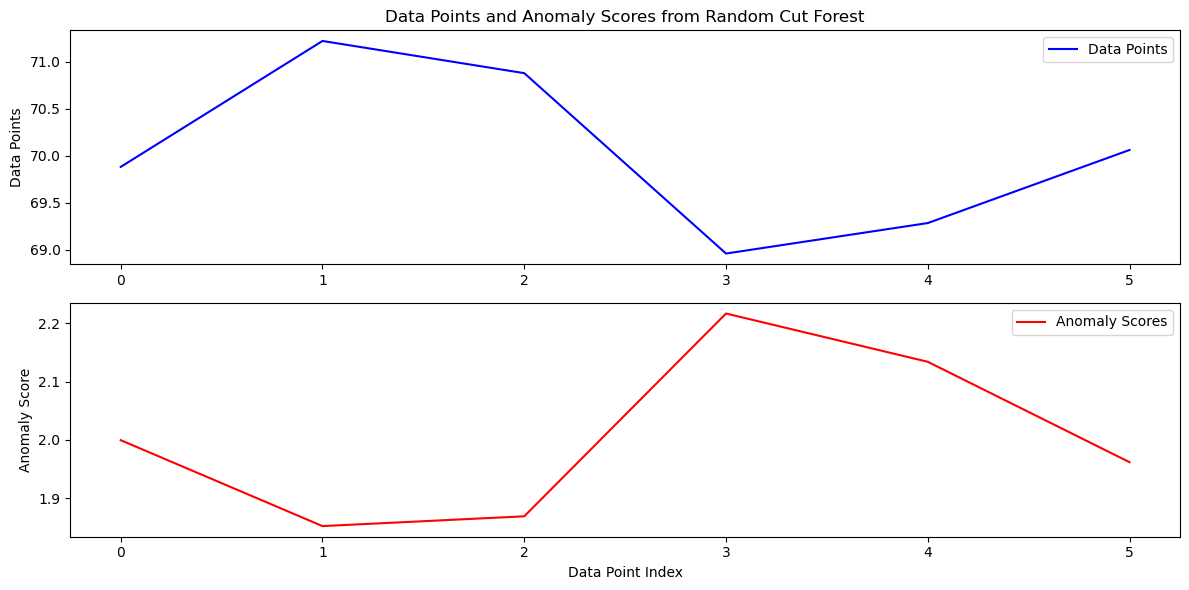

In [54]:
plt.figure(figsize=(12, 6))

# Plotting the data points
plt.subplot(2, 1, 1)  # This allows for a multi-plot of data and scores
plt.plot(machine_data_numpy[:6], 'b-', label='Data Points')
plt.title('Data Points and Anomaly Scores from Random Cut Forest')
plt.ylabel('Data Points')
plt.legend()

# Plotting the anomaly scores
plt.subplot(2, 1, 2)
plt.plot(scores, 'r-', label='Anomaly Scores')
plt.ylabel('Anomaly Score')
plt.xlabel('Data Point Index')
plt.legend()

plt.tight_layout()
plt.show()

## prediction using invoke_endpoint not working

In [29]:
# Initialize the SageMaker Runtime client
sagemaker_runtime = boto3.client('sagemaker-runtime')

In [30]:
# Example data to be predicted
data = {"features": [5.1, 3.5, 1.4, 0.2]}
serialized_data = json.dumps(machine_data_numpy[:6].tolist())

In [39]:

# Invoke the endpoint
response = sagemaker_runtime.invoke_endpoint(
    EndpointName='randomcutforest-2023-12-08-05-56-39-318',
    ContentType='text/csv',
    Accept= 'application/json',
    Body=serialized_data
)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from model with message "unable to evaluate payload provided". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/randomcutforest-2023-12-08-05-56-39-318 in account 287758680514 for more information.

In [32]:
serialized_data

'[[69.88083514], [71.22022706], [70.87780496], [68.95939994], [69.28355102], [70.06096581]]'

In [35]:
json.dumps(machine_data_numpy[:6])

TypeError: Object of type ndarray is not JSON serializable

In [38]:
df['value']

timestamp
2013-07-04 00:00:00    69.880835
2013-07-04 01:00:00    71.220227
2013-07-04 02:00:00    70.877805
2013-07-04 03:00:00    68.959400
2013-07-04 04:00:00    69.283551
                         ...    
2014-05-28 11:00:00    72.370206
2014-05-28 12:00:00    72.172956
2014-05-28 13:00:00    72.046565
2014-05-28 14:00:00    71.825226
2014-05-28 15:00:00    72.584089
Name: value, Length: 7267, dtype: float64

In [51]:
region=boto3.Session().region_name

downloaded_data_prefix = "datasets/tabular/anomaly_benchmark_taxi"
data_filename = "NAB_nyc_taxi.csv"
downloaded_data_bucket = f"sagemaker-example-files-prod-{region}"
downloaded_data_prefix = "datasets/tabular/anomaly_benchmark_taxi"

data_filename = "NAB_nyc_taxi.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)
taxi_data = pd.read_csv(data_filename, delimiter=",")


'sagemaker-example-files-prod-us-east-1'

In [52]:
taxi_data

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [53]:
taxi_data.values[:, 1]

array([10844, 8127, 6210, ..., 27309, 26591, 26288], dtype=object)

In [57]:
import numpy as np
def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data - shingle_size, shingle_size))

    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n : (n + shingle_size)]
    return shingled_data

In [58]:
shingle_size = 48

taxi_data_shingled = shingle(taxi_data.values[:, 1], shingle_size)
print(taxi_data_shingled)

[[10844.  8127.  6210. ... 21733. 20104. 16111.]
 [ 8127.  6210.  4656. ... 20104. 16111. 13370.]
 [ 6210.  4656.  3820. ... 16111. 13370.  9945.]
 ...
 [26874. 26928. 26000. ... 23719. 24670. 25721.]
 [26928. 26000. 25778. ... 24670. 25721. 27309.]
 [26000. 25778. 23304. ... 25721. 27309. 26591.]]


In [59]:
taxi_data_shingled.shape

(10272, 48)